Привет, меня зовут Максим и я буду проверять твой проект.
<br>Небольшая вступительная часть и начнем работу)
<br> Если не против, то предлагаю общаться на "ты". Если это не удобно - дай знать, и мы перейдем на "вы". Моя основная цель — не указать на совершенные ошибки, а поделиться своим опытом и помочь сделать твой проект лучше. Для этого я буду использовать разный стиль оформления комментариев. 
<div class="alert alert-block alert-success">
✔️ Все хорошо.
</div>

<div class="alert alert-warning">
⚠️ Критических замечаний нет, но есть возможность сделать твою работу лучше.
</div>

<div class="alert alert-block alert-danger">
❌ Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>


Давай работать над проектом в диалоге: если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом.
Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> ...
</div>
Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии. Всё это поможет выполнить повторную проверку твоего проекта оперативнее».  

# Прогнозирование температуры звезды

**Основной целью проекта** является создание нейронной сети, способной определять температуру на поверхности обнаруженных звезд. Заказчиком данного проекта выступает обсерватория "Небо на ладони". В распоряжении обсерватории имеются данные о характеристиках 240 изученных звезд.

**Ход работы:**
1. [Загрузка и описание данных](#loading)
2. [Предобработка и анализ данных](#preprocessing)
3. [Построение базовой нейронной сети](#basic)
4. [Улучшение нейронной сети](#network)

<div class="alert alert-success">
<h4>✔️ Комментарий ревьюера</h4>
Здорово, что во вступлении к проекту есть заголовок, краткое описание проекта и его цель, а также план работы.

Вступление станет лучше, если добавить в него описание данных, тогда получатель отчета сможет быстрей его понять.

</div>

<a id='loading'></a>

## Загрузка данных

In [294]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, ceil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-success">
<h4>✔️ Комментарий ревьюера</h4>
Отлично, все нужные библиотеки импортированы в начале ноутбука. Это хорошая практика.
</div>

In [2]:
# загрузка данных
data = pd.read_csv('/datasets/6_class.csv')
data.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


### Описание данных
- `Luminosity(L/Lo)` — относительная светимость, светимость звезды относительно Солнца
- `Radius(R/Ro)` — относительный радиус, радиус звезды относительно радиуса Солнца
- `Absolute magnitude(Mv)` — абсолютная звёздная величина, физическая величина, характеризующая блеск звезды
- `Star color` - звёздный цвет, цвет звезды, который определяют на основе спектрального анализа
- `Star type` - тип звезды
- `Temperature (K)` —  абсолютная температура, температура на поверхности звезды в Кельвинах

Колонка `Unnamed` просто дублирует индекс - удалим ее. Остальные колонки переименуем, убрав пояснения в скобках, для простоты использования.

In [3]:
data.drop(columns='Unnamed: 0', inplace=True)
data.columns = ['temperature', 'luminosity', 'radius', 'magnitude', 'star_type', 'star_color']
data.head()

,temperature,luminosity,radius,magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


<a id='preprocessing'></a>
## Предобработка и анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  240 non-null    int64  
 1   luminosity   240 non-null    float64
 2   radius       240 non-null    float64
 3   magnitude    240 non-null    float64
 4   star_type    240 non-null    int64  
 5   star_color   240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


В датасете представлена информация о 240 звездах, пропусков не наблюдается. Типы данных соответствуют ожидаемым.

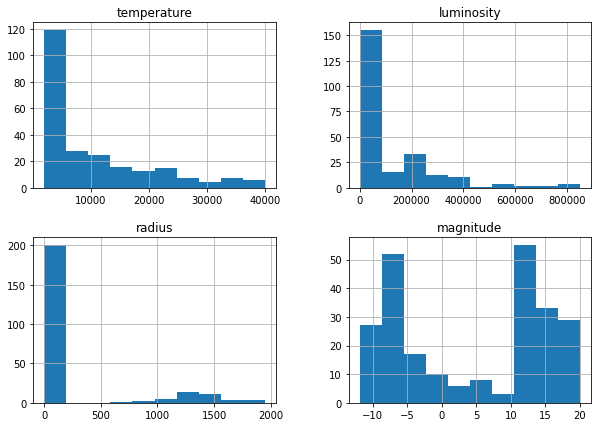

In [9]:
# temperature
data[['temperature', 'luminosity', 'radius', 'magnitude']].hist(figsize=(10, 7))
plt.show()

Данные в столбцах `temperature` и `luminosity` распределены экспоненциально, аномально выбивающихся значений не наблюдается. Рассмотрим столбец `radius` отдельно: 

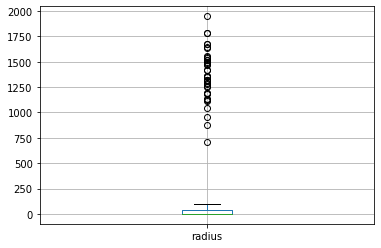

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: radius, dtype: float64

In [13]:
data.boxplot('radius')
plt.show()

data['radius'].describe()

Судя по последнему графику, в столбце с радиусом наблюдается множество выбросов (значения больше 500)

In [19]:
print(f'Процент выбросов: {round(data[data["radius"] > 500].shape[0] / data.shape[0]*100, 2)}%')
print(f'Число строк: {data[data["radius"] > 500].shape[0]}')

Процент выбросов: 16.67%
Число строк: 40


Однако, нецелесообразно удалять эти выбросы из датасета, поскольку он имеет небольшой объем (всего 240 строк). Следует сохранить эти строки, так как в случае, если в будущем нейросети будут предоставлены характеристики звезд с большими радиусами, она не сможет корректно обработать такие данные.

Что касается категориальных признаков, данные в столбце `star_type` уже закодированы. Посмотрим на столбец `star_color`:

In [20]:
data['star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
white                   3
Yellowish White         3
Whitish                 2
Orange                  2
yellowish               2
Blue white              1
Blue                    1
White-Yellow            1
Pale yellow orange      1
Blue-White              1
Orange-Red              1
Yellowish               1
Name: star_color, dtype: int64

Можно заметить, что в столбце присутствует множество неявных дубликатов, обусловленных различным написанием одних и тех же цветов.

In [23]:
data['star_color'] = data['star_color'].str.lower().str.strip().str.replace(' ', '-')
data['star_color'].value_counts()

red                   112
blue                   56
blue-white             41
white                  10
yellow-white            8
yellowish               3
yellowish-white         3
whitish                 2
orange                  2
pale-yellow-orange      1
orange-red              1
white-yellow            1
Name: star_color, dtype: int64

Чтобы сократить количество категорий, выделим три основные: "red", "blue" и "other". \
В последнюю категорию войдут все остальные цвета ("white", "yellow" и т.д.)

In [30]:
def main_color(color):
    if 'blue' in color:
        return 'blue'
    if 'red' in color:
        return 'red'
    
    return 'other'

data['star_color'] = data['star_color'].apply(main_color)
data['star_color'].value_counts()    

red      113
blue      97
other     30
Name: star_color, dtype: int64

<div class="alert alert-success">
<h4>✔️ Комментарий ревьюера</h4>
Хороший, подробный анализ данных. Наглядно показано, с чем идет работа в проекте. Отлично, что были замечены и исправлены неявные дубликаты в цветах звезд - они могли негативно повлиять на будущую модель.
</div>

Разбиение данных на выборки:

In [443]:
features = data.drop(columns=['temperature'])
target = data['temperature']

# выделение обучающей, валидационной и тестовой выборок
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.30, 
                                                                            shuffle=True, random_state=42)

features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, test_size=0.5, 
                                                                            shuffle=True, random_state=42)


print('Размер обучающей выборки:', features_train.shape[0])
print('Размер валидационной выборки:', features_valid.shape[0])
print('Размер тестовой выборки:', features_test.shape[0])

Размер обучающей выборки: 168
Размер валидационной выборки: 36
Размер тестовой выборки: 36


<div class="alert alert-warning">
<h4>⚠️ Комментарий ревьюера</h4>
Как уже было отмечено выше, размер выборки совсем небольшой. Возможно, стоит отказаться от использования валидационной выборки в пользу расширения тренировочной и тестовой.
</div> 

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Помню с прошлых проектов, что обычно ругают, если не проверяешь качество модели на тестовой выборке. Или же, если идет отказ от валидационной, стоит делать проверку качества и подбор оптимальных параметров только на тренировочной?
</div>

<div class="alert alert-success">
<h4>✔️ Комментарий ревьюера v2</h4>
Использование и тестовой, и валидационной выборки - это хорошая практика. Однако при недостаточном размере выборки, можно отказаться от разделения и обучать модель на тренировочной выборке, а net.eval проводить на тестовой. Таким образом, метрика, полученная при net.eval на тестовой выборке будет считаться итоговой метрикой модели.
</div>

Шкалирование численных признаков + OHE категориальных:

In [444]:
# масштабирование
numeric = ['luminosity', 'radius', 'magnitude']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [445]:
# кодирование нечисловых столбцов (OHE)
categorical = ['star_type', 'star_color']
enc = OneHotEncoder(sparse=False, drop='first')
enc.fit(features_train[categorical])

# наименования столбцов
ohe_column_names = []
for feature, categories in zip(categorical, enc.categories_):
    ohe_column_names.extend([f"{feature}_{category}" for category in categories[1:]])

# train
encoded_train = pd.DataFrame(enc.transform(features_train[categorical]), index=features_train.index, columns=ohe_column_names)
features_train = pd.concat([features_train, encoded_train], axis=1)
features_train.drop(columns=['star_type', 'star_color'], inplace=True)

# valid
encoded_valid = pd.DataFrame(enc.transform(features_valid[categorical]), index=features_valid.index, columns=ohe_column_names)
features_valid = pd.concat([features_valid, encoded_valid], axis=1)
features_valid.drop(columns=['star_type', 'star_color'], inplace=True)

# test
encoded_test = pd.DataFrame(enc.transform(features_test[categorical]), index=features_test.index, columns=ohe_column_names)
features_test = pd.concat([features_test, encoded_test], axis=1)
features_test.drop(columns=['star_type', 'star_color'], inplace=True)


display(features_train.head())
display(features_test.head())

,luminosity,radius,magnitude,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_other,star_color_red
29,-0.605495,-0.432609,0.921181,0.0,1.0,0.0,0.0,0.0,1.0,0.0
124,-0.605495,-0.432415,1.215105,0.0,0.0,0.0,0.0,0.0,0.0,1.0
75,-0.605495,-0.431926,0.696871,1.0,0.0,0.0,0.0,0.0,0.0,1.0
82,-0.605495,-0.432616,0.892176,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,-0.605495,-0.432413,1.201569,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,luminosity,radius,magnitude,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_other,star_color_red
101,4.246425,-0.404254,-1.042498,0.0,0.0,0.0,1.0,0.0,0.0,0.0
109,1.495213,-0.296807,-0.999957,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15,-0.605495,-0.432149,0.823529,1.0,0.0,0.0,0.0,0.0,0.0,1.0
79,-0.605495,-0.432309,0.911513,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9,-0.605495,-0.432372,1.111651,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<div class="alert alert-success">
<h4>✔️ Комментарий ревьюера</h4>
Предобработка данных проведена корректно. Такие данные можно подавать в нейросеть.
</div>

<div class="alert alert-warning">
<h4>⚠️ Комментарий ревьюера</h4>
Небольшое замечание по комментарию тут:
    
    enc = OneHotEncoder(sparse=False, drop='first') # неизвестные категории будут столбцами с 0
    
Зануляет неизвестные категории параметр handle_unknown='ignore', и он не используется с drop='first'.
</div> 

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Вот что бывает, когда пишешь проект поздно ночью и перебираешь несколько вариантов) Спасибо, что указали на неточность - убрала. 
</div>

<div class="alert alert-success">
<h4>✔️ Комментарий ревьюера v2</h4>
👍
</div>

<a id='basic'></a>
## Построение базовой нейронной сети

In [446]:
# тензоры
X_train = torch.FloatTensor(features_train.values)
X_valid = torch.FloatTensor(features_valid.values)
X_test = torch.FloatTensor(features_test.values)

y_train = torch.FloatTensor(target_train.values).reshape(-1, 1)
y_valid = torch.FloatTensor(target_valid.values).reshape(-1, 1)
y_test = torch.FloatTensor(target_test.values).reshape(-1, 1)

Попробуем создать нейросеть с одним скрытым слоем:

In [447]:
# функция потерь
loss = nn.MSELoss()

In [448]:
# функция для вычисления RMSE
def rmse(y_torch, y_pred):
    return sqrt(mean_squared_error(y_torch.detach().numpy(), y_pred.detach().numpy()))

In [459]:
# функция для построения графика
def plot_predictions(y_true, preds):
    star_indices = [str(x) for x in np.arange(20)] # номера звезд
    plt.figure(figsize=(15, 5))  # устанавливаем размер картинки (ширина, высота)

    plt.bar(x=star_indices, height=y_true.detach().numpy().flatten()[:20], label='Факт', align='edge', width=0.5)
    plt.bar(x=star_indices, height=preds.detach().numpy().flatten()[:20], label='Прогноз', width=0.5)

    plt.xlabel('Порядковый номер звезды')
    plt.ylabel('Температура (К)')
    plt.title('Факт — Прогноз')

    plt.legend()
    plt.show()

<div class="alert alert-success">
<h4>✔️ Комментарий ревьюера</h4>
Молодец, что используешь функцию для построения графиков. Так все графики будут в одном стиле, а код не будет дублироваться.
</div>

In [486]:
n_in_neurons = X_train.shape[1]    # входной слой
n_hidden_neurons_1 = 500           # нейроны скрытого слоя
n_hidden_neurons_2 = 1000          # нейроны скрытого слоя
n_out_neurons = 1                  # выходной слой

# класс нейронной сети
net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
)

# оптимизатор
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

<div class="alert alert-warning">
<h4>⚠️ Комментарий ревьюера</h4>
Небольшое замечание по формулировке в комментариях: сеть имеет один скрытый слой:
    
    nn.Linear(n_in_neurons, n_hidden_neurons_1) -- входной слой
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) -- скрытый слой
    nn.Linear(n_hidden_neurons_2, n_out_neurons) -- выходной слой

</div> 

<div class="alert alert-warning">
<h4>⚠️ Комментарий ревьюера</h4>
Для выходного слоя может потребоваться функция активации, как и для всех остальных слоев. 
    
Целевая характеристика, которую мы определяем - это температура звезды в Кельвинах. Физически температура в Кельвинах не может быть ниже нуля. Следовательно, для снижения ошибки стоит применить функцию активации для выходного слоя, которая не даст на выходе получить отрицательное значение (как ReLU), либо сильно его уменьшит (как LeakyReLU).
    
Добавление функции активации к выходному слою может изменить размерность выходного тензора (перевести строку в столбец), поэтому может потребоваться добавление метода flatten() в прямой проход и расчет метрики при обучении модели.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Комментарии по скрытому слою поправила. Насчет выходного слоя - учту на будущее, как один из вариантов. Просто в теории было сказано, что для задач регрессии стоит использовать линейную функцию активации на последнем слое, а это, как понимаю, оно и есть (без указания доп.функции).
</div>

<div class="alert alert-success">
<h4>✔️ Комментарий ревьюера v2</h4>
Да, линейная функция активации тут тоже подходит. Я и написал этот комментарий как "на будущее")
</div>

Epoch: 0 RMSE (valid): 13456.192626445269
Epoch: 200 RMSE (valid): 8129.4464756218185
Epoch: 400 RMSE (valid): 6388.135252168664
Epoch: 600 RMSE (valid): 5389.234268428122
Epoch: 800 RMSE (valid): 4773.205002930421
Epoch: 999 RMSE (valid): 4349.203375332085


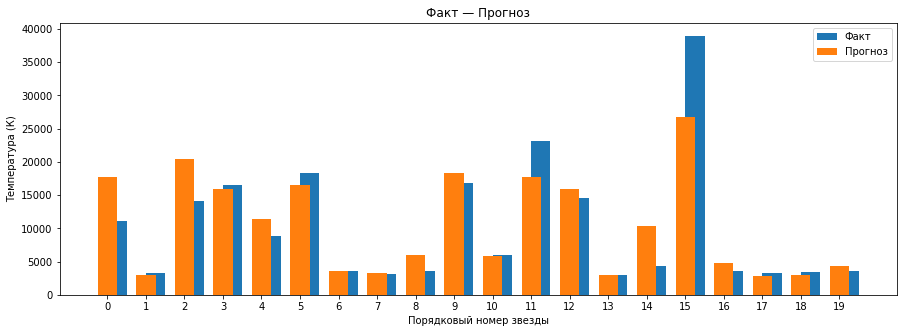

RMSE 4349.203375332085
CPU times: user 58.2 s, sys: 1.14 s, total: 59.4 s
Wall time: 59.8 s


In [487]:
%%time
num_epochs = 1000
batch_size = len(X_train)

def train_net(net, num_epochs, batch_size, epoch_check=200, plot_preds=False):
    num_batches = ceil(len(X_train)/batch_size)     # количество батчей
    
    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train)) # случайная перестановка индексов объектов
        
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size    # номер стартового объекта батча
            optimizer.zero_grad()
            
            batch_indexes = order[start_index:start_index+batch_size] # индексы объектов текущего обатча
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
  
            preds = net.forward(X_batch)            # прямое распространение на обучающих данных
            loss_value = loss(preds, y_batch)       # вычисление значения функции потерь
            loss_value.backward()                   # вычисление градиентов
    
            optimizer.step()

        if epoch % epoch_check == 0 or epoch == num_epochs-1:
            net.eval()                         # перевод сети в режим предсказания
            valid_preds = net.forward(X_valid) # прямое распространение на валидационных данных
            rmse_valid = rmse(y_valid, valid_preds)
            print('Epoch:', epoch, 'RMSE (valid):', rmse_valid)
            
            if epoch == num_epochs-1 and plot_preds == True:
                plot_predictions(y_valid, valid_preds) # график
            
    return net, rmse_valid

net, rmse_valid = train_net(net, num_epochs, batch_size, plot_preds=True)
print('RMSE', rmse_valid)

В базовой нейронной сети с одним скрытым слоем удалось дойти до RMSE 4400 (округленно) на валидационных данных. Как видно по графику, модель достаточно хорошо предсказывает низкую и среднюю температуру звезд. С более высокими значениями температуры нейросеть справляется хуже.

Попробуем усовершенствовать нейросеть. 

<div class="alert alert-warning">
<h4>⚠️ Комментарий ревьюера</h4>
Хороший результат обучения сети. В выводе небольшой недочет: у сети один скрытый слой. Также можно в выводе отметить, на каких звездах модель работает точно, а на каких часто ошибается.
</div> 

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Вывод подкорректировала.
</div>

<div class="alert alert-success">
<h4>✔️ Комментарий ревьюера v2</h4>
👍
</div>

<a id='network'></a>
## Улучшение нейронной сети

In [422]:
# используемые параметры
n_in_neurons = X_train.shape[1]    # входной слой
n_hidden_neurons_1 = 500           # скрытый слой 1
n_hidden_neurons_2 = 1000          # скрытый слой 2
n_out_neurons = 1                  # выходной слой

num_epochs = 1000                   # количество эпох

Для начала определим оптимальный размер батча:

In [470]:
%%time
batch_sizes = [X_train.shape[0], 50, 25]

for batch_size in batch_sizes:
    # класс нейронной сети
    net = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_2, n_out_neurons)
    )

    # оптимизатор
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
        
    # обучение нейросети
    print(f'Batch_size={batch_size}')
    new_net, rmse_score = train_net(net, num_epochs, batch_size)
    print()

Batch_size=168
Epoch: 0 RMSE (valid): 13456.249105898716
Epoch: 200 RMSE (valid): 8176.517596140792
Epoch: 400 RMSE (valid): 6474.030274875149
Epoch: 600 RMSE (valid): 5496.130275020781
Epoch: 800 RMSE (valid): 4867.693498978751
Epoch: 999 RMSE (valid): 4413.5758745035755

Batch_size=50
Epoch: 0 RMSE (valid): 13454.532619158497
Epoch: 200 RMSE (valid): 5496.721204500006
Epoch: 400 RMSE (valid): 4305.758469770454
Epoch: 600 RMSE (valid): 4116.216952494123
Epoch: 800 RMSE (valid): 4391.3382925937285
Epoch: 999 RMSE (valid): 4499.575757779838

Batch_size=25
Epoch: 0 RMSE (valid): 13452.545930046104
Epoch: 200 RMSE (valid): 4690.510633182703
Epoch: 400 RMSE (valid): 4072.5436768683035
Epoch: 600 RMSE (valid): 4232.274093203322
Epoch: 800 RMSE (valid): 4607.129040953813
Epoch: 999 RMSE (valid): 4820.192527275233

CPU times: user 11min 49s, sys: 16.1 s, total: 12min 5s
Wall time: 12min 10s


Минимальное значение RMSE получено при размере батча 25 на 401-й эпохе обучения - 4072. Далее уже наблюдается переобучение нейронной сети и возрастание метрики. Теперь подберем значение параметра dropout:

In [488]:
%%time
batch_size = 25
num_epochs = 1000
dropout_values = [0.2, 0.5, 0.8]

for p in dropout_values:
    # класс нейронной сети
    net = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.ReLU(),
        nn.Dropout(p=p),
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.ReLU(),
        nn.Dropout(p=p),
        nn.Linear(n_hidden_neurons_2, n_out_neurons)
    )

    # оптимизатор
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
        
    # обучение нейросети
    print(f'Dropout p={p}')
    new_net, rmse_score = train_net(net, num_epochs, batch_size)
    print()

Dropout p=0.2
Epoch: 0 RMSE (valid): 13452.51262775843
Epoch: 200 RMSE (valid): 4663.814962024116
Epoch: 400 RMSE (valid): 4104.174947538178
Epoch: 600 RMSE (valid): 4314.264711396369
Epoch: 800 RMSE (valid): 4659.721450902403
Epoch: 999 RMSE (valid): 4785.601111668209

Dropout p=0.5
Epoch: 0 RMSE (valid): 13452.839105556865
Epoch: 200 RMSE (valid): 4699.93957407965
Epoch: 400 RMSE (valid): 4111.362061409819
Epoch: 600 RMSE (valid): 4240.96522032426
Epoch: 800 RMSE (valid): 4612.822780033935
Epoch: 999 RMSE (valid): 4734.810027868067

Dropout p=0.8
Epoch: 0 RMSE (valid): 13454.869750391492
Epoch: 200 RMSE (valid): 4644.577268169838
Epoch: 400 RMSE (valid): 4150.868101975779
Epoch: 600 RMSE (valid): 4412.851232479971
Epoch: 800 RMSE (valid): 4726.969853933913
Epoch: 999 RMSE (valid): 4889.412030091144

CPU times: user 14min 10s, sys: 18.4 s, total: 14min 29s
Wall time: 14min 36s


Самое низкое значение ошибки получено на валидационных данных при p=0.2 с размером батча 25 на 401-й эпохе обучения - 4104

## Выводы

**Финальная проверка на тестовой выборке**: \
Соединим train и valid выборки, обучим модель полученных данных и проверим на тестовых.

In [489]:
X_train_valid = torch.cat((X_train, X_valid), 0)
y_train_valid = torch.cat((y_train, y_valid), 0)

In [490]:
batch_size = 25
num_batches = ceil(len(X_train_valid)/batch_size)     # количество батчей

n_in_neurons = X_train.shape[1]    # входной слой
n_hidden_neurons_1 = 500           # скрытый слой 1
n_hidden_neurons_2 = 1000          # скрытый слой 2
n_out_neurons = 1                  # выходной слой

num_epochs = 401

In [491]:
# класс нейронной сети
net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
)

# оптимизатор
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

RMSE (test): 6942.549675731532


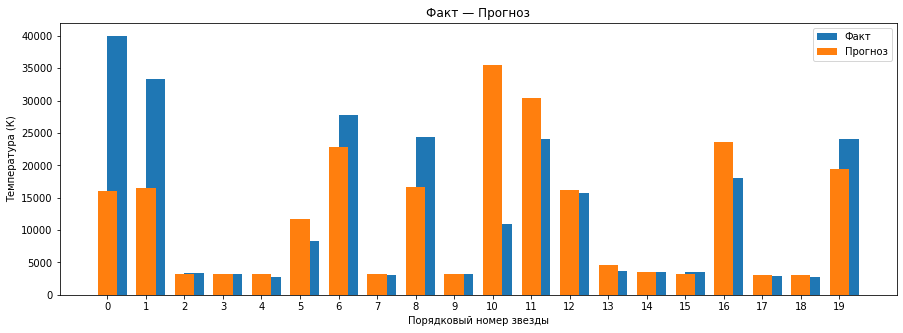

CPU times: user 6min 14s, sys: 8.17 s, total: 6min 22s
Wall time: 6min 25s


In [493]:
%%time
for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train_valid)) # случайная перестановка индексов объектов
        
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size    # номер стартового объекта батча
        optimizer.zero_grad()
            
        batch_indexes = order[start_index:start_index+batch_size] # индексы объектов текущего обатча
        X_batch = X_train_valid[batch_indexes]
        y_batch = y_train_valid[batch_indexes]
  
        preds = net.forward(X_batch)            # прямое распространение на обучающих данных
        loss_value = loss(preds, y_batch)       # вычисление значения функции потерь
        loss_value.backward()                   # вычисление градиентов
    
        optimizer.step()

net.eval()                       # перевод сети в режим предсказания
test_preds = net.forward(X_test) # прямое распространение на тестовых данных
rmse_test = rmse(y_test, test_preds)
print('RMSE (test):', rmse_test)
            
plot_predictions(y_test, test_preds) # график

К сожалению, результаты на тестовой выборке оказались хуже. Полученная метрика RMSE: 6942.

**Вывод:**

В рамках данного проекта была создана нейросеть, позволяющая определять температуру на поверхности обнаруженных звезд. Данные перед обучением были исследованы на выбросы и некорректные значения, категориальные признаки закодированы методом OneHotEncoding, численные - отшкалированы.

Нейросеть, показавшая лучшие результаты, содержала 2 скрытых слоя с 500 нейронами на первом и 1000 нейронами на втором и обучалась в течение 401 эпохи. Выбранный размер батча - 25 строк, значение параметра p=0.2 (для регуляризации методом dropout). На валидационной выборке удалось получить значение метрики меньше требуемого: **4104**. Однако на тестовом наборе нейросеть показала себя хуже - **6942**. К возможным причинам такого поведения нейросети, в частности, можно отнести маленький объем датасета, неравномерное распределение данных по выборкам и наличие большого количества выбросов в одном из столбце, удалять которые не стали, чтобы еще сильнее не урезать датасет.

<div class="alert alert-success">
<h4>✔️ Комментарий ревьюера</h4>
Отличный итоговый вывод. Наглядно показана проделанная работа, и обоснованы полученные результаты.
</div>

<div style="border:solid Chocolate 2px; padding: 40px">

<h4>Резюме по работе:</h4>

Проделана огромная работа, у тебя получился хороший проект! 

Особенно хочется отметить внимание к деталям при работе с данными и подробные выводы. Чувствуется хороший исследовательский подход.

Стоит обратить внимание на некоторые формулировки в выводах и комментариях по ходу работы. В комментариях выше я указал, куда именно надо посмотреть)
    
Критических замечаний нет, работа может быть принята.
    
Возвращаю на доработку, чтобы была возможность внести последние правки, если есть такое желание. Также можно задать вопросы по проекту, если они остались. Можешь оформить их комментарием под этим резюме.
    
Если правки не планируются и вопросов нет, просто верни проект на ревью и я приму работу.

</div> 

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Большое спасибо за ревью!
</div>